### QM9 testing for compressed SOAP features using an approximate GP

Quick and dirty test using a random features approximated GP; we can obtain
an MAE < 0.35 kcal/mol without too much effort. Alternative feature
compression schemes may enable us to acheive better performance with
an even smaller number of features (the current mu=1 nu=1 compression
yields 1920 features per atom, which at up to 29 atoms per molecule yields
a fairly large number of features per datapoint).

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from xGPR.xGP_Regression import xGPRegression
from xGPR.data_handling.dataset_builder import build_offline_sequence_dataset

if "qm9_data" not in os.getcwd():
    os.chdir(os.path.join("..", "qm9_data", "qm9_agnostic_features"))

In [2]:
def get_batched_multitask_files(target, dtype):
    os.chdir(target)
    xfoldedfiles, yfiles = [], []
    xfoldedfiles = [os.path.abspath(f) for f in os.listdir() if f.endswith("xfolded.npy")]
    yfiles = [os.path.abspath(d) for d in os.listdir() if d.endswith("yvalues.npy")]
    xfoldedfiles.sort()
    yfiles.sort()
    os.chdir("..")
    return xfoldedfiles, yfiles

In [3]:
train_x_folded, trainy = get_batched_multitask_files("train", "u298")
valid_x_folded, validy = get_batched_multitask_files("valid", "u298")
test_x_folded, testy = get_batched_multitask_files("test", "u298")

In [4]:
#Using a Graph RBF kernel -- a squared exponential evaluated pairwise across all pairs of
#atoms in any two mols. We can also use GraphPoly or GraphArcCosine (pairwise evals of
#arc cosine or polynomial) with similar results.
train_dset = build_offline_sequence_dataset(train_x_folded, trainy, skip_safety_checks = True)
mod = xGPRegression(training_rffs = 1024, fitting_rffs = 8192, device = "gpu",
                   kernel_choice = "GraphRBF", verbose = True,
                   kernel_specific_params = {"polydegree":2, "order":2, "intercept":True})


#This function provides an initial "quick and dirty" hyperparameter tuning run to establish
#an approximate location for a good lengthscale.

_, _, nmll, scores = mod.tune_hyperparams_crude_bayes(train_dset)

starting_tuning
Grid point 0 acquired.
Grid point 1 acquired.
Grid point 2 acquired.
Grid point 3 acquired.
Grid point 4 acquired.
Grid point 5 acquired.
Grid point 6 acquired.
Grid point 7 acquired.
Grid point 8 acquired.
Grid point 9 acquired.
New hparams: [0.6852147]
Additional acquisition 10.
New hparams: [0.5452972]
Additional acquisition 11.
New hparams: [-0.0684114]
Additional acquisition 12.
New hparams: [1.1201818]
Additional acquisition 13.
New hparams: [-2.0555689]
Additional acquisition 14.
New hparams: [-0.9295606]
Additional acquisition 15.
New hparams: [2.0118921]
Additional acquisition 16.
New hparams: [0.2064017]
Additional acquisition 17.
New hparams: [-3.0289069]
Additional acquisition 18.
New hparams: [0.9243384]
Additional acquisition 19.
New hparams: [4.149718]
Additional acquisition 20.
New hparams: [3.1080434]
Additional acquisition 21.
New hparams: [-0.259745]
Additional acquisition 22.
New hparams: [-4.191255]
Additional acquisition 23.
New hparams: [0.4194954

We could further fine-tune hyperparameters as shown below, which will generally lead to
improved performance, but for now we'll just use the (approximate)
location of the best lengthscale from the crude tuning, setting the noise value to a much lower
value since we know the data is (close to) noise free.

In [14]:
#bounds = mod._run_pretuning_prep(train_dset, 123,
#                  None, "approximate")
#mod.training_rffs = 8192
#sigma_vals_n = [0.0, 0.5, 1.0]
#for sigma_val in sigma_vals_n:
#    hparams = np.array([-6.5,1,sigma_val])
#    nmll = mod.approximate_nmll(hparams, train_dset, max_rank = 1500,
#                    nsamples = 25, random_seed = 123, niter = 1000,
#                    tol = 1e-7, pretransform_dir = "/ssd1/gpr_data/fitting",
#                    preconditioner_mode = "srht_2")
#    nmll_vals.append(nmll)

In [6]:
hparams = np.array([-6.0, 0, 0.5])

In [9]:
#The more random features (RFFs) we use, the better the model approximates an exact Gaussian
#process, and the better performance will be, although there are usually sharply diminishing
#returns. 16384 yields slightly better performance than 8192, and 32768 is a further small
#improvement. For inference, of course, a smaller number of RFFs is better.

mod.fitting_rffs = 16384


#We'll pre-generate the random features and save them on disk. This is not fast, but
#is faster when each graph has a large number of associated features,
#as with SOAP, since loading the raw data is time consuming (each molecule has
#a very large number of associated features -- up to 29 * 1920 = 55680) so
#we would prefer to avoid loading any batch of raw data more than once.
p_dset = mod.pretransform_data(train_dset, pretransform_dir = os.getcwd(), preset_hyperparams = hparams)

print("Pretransform done.")

#A larger preconditioner rank speeds up fitting by reducing number of iterations, a smaller rank makes
#preconditioner construction faster. 1024 is a compromise.
preconditioner, ratio = mod.build_preconditioner(p_dset, max_rank = 1024, method="srht_2", preset_hyperparams = hparams)
mod.fit(p_dset, preconditioner = preconditioner, tol = 1e-7, max_iter = 1000,
        suppress_var = True)
p_dset.delete_dataset_files()

Now pretransforming data.
Pretransform done.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 110 complete.
Chunk 120 complete.
Chunk 130 complete.
Chunk 140 complete.
Chunk 150 complete.
Chunk 160 complete.
Chunk 170 complete.
Chunk 180 complete.
Chunk 190 complete.
Chunk 200 complete.
Chunk 210 complete.
Chunk 220 complete.
Chunk 230 complete.
Chunk 0 complete.
Chunk 10 complete.
Chunk 20 complete.
Chunk 30 complete.
Chunk 40 complete.
Chunk 50 complete.
Chunk 60 complete.
Chunk 70 complete.
Chunk 80 complete.
Chunk 90 complete.
Chunk 100 complete.
Chunk 110 complete.
Chunk 120 complete.
Chunk 130 complete.
Chunk 140 complete.
Chunk 150 complete.
Chunk 160 complete.
Chunk 170 complete.
Chunk 180 complete.
Chunk 190 complete.
Chunk 200 complete.
Chunk 210 complete.
Chunk 220 complete.
Chunk 230 complete.
starting fitting


Mean absolute error is 0.3922605007324626 kcal/mol


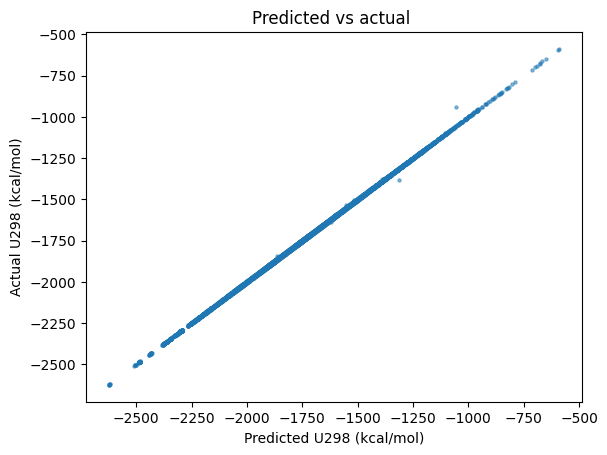

In [10]:
preds = [mod.predict(np.load(xfile), get_var = False) for xfile in valid_x_folded + test_x_folded]
gt = [np.load(yfile) for yfile in validy + testy]

    
preds = np.concatenate(preds)
gt = np.concatenate(gt)
plt.scatter(preds, gt, s=5, alpha=0.5)
plt.xlabel("Predicted U298 (kcal/mol)")
plt.ylabel("Actual U298 (kcal/mol)")
plt.title("Predicted vs actual ")
print(f"Mean absolute error is {np.mean(np.abs(gt - preds))} kcal/mol")